In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
!pip install transformers==3.3.1
from transformers import AutoModel, AutoTokenizer
from torch import cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_train.csv', delimiter='\t', names=['text','label','nan'])
train = train.drop(columns=['nan'])
# train['label'].value_counts()
# train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)
train.head(9)

,text,label
0,movie vara level la Erika poguthu,Not_offensive
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil
2,Padam nalla comedy padama irukum polaye..,Not_offensive
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive
5,ippo intha trailer ah parkuravana oru like pod...,Not_offensive
6,En thalaivan yogi babu irukkaar. Padam vera le...,Not_offensive
7,Nerkonda parvai... Sema sema sema trailer,Not_offensive
8,ஏய் இது 96 யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,Not_offensive


In [ ]:
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)
train.head(9)

,text,label
0,movie vara level la Erika poguthu,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,4
2,Padam nalla comedy padama irukum polaye..,0
3,karthick subburaj anne .... intha padam vetri ...,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,0
5,ippo intha trailer ah parkuravana oru like pod...,0
6,En thalaivan yogi babu irukkaar. Padam vera le...,0
7,Nerkonda parvai... Sema sema sema trailer,0
8,ஏய் இது 96 யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,0


In [ ]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_dev.csv', delimiter='\t', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.head(9)

,text,label
0,Handsome hunk keri vaa thalaivaa,Not_offensive
1,தென்காசி மாவட்டம் நாடார் சமுதாயம் சார்பாக வாழ்...,Not_offensive
2,je vous aime bravo pour clip de merde que j éc...,not-Tamil
3,சிறப்பு..... மேலும் இது போன்ற படைப்புகள் மிக அ...,Not_offensive
4,Vera level BGM .. semma trailer. 🤞,Not_offensive
5,என்னடா பண்ணி வச்சிருக்கீங்க ?!!!! அந்த அம்மாவ ...,Offensive_Targeted_Insult_Group
6,"#kaappaan is gonna be a massive hit ,#suriya #...",Not_offensive
7,250k likes to go.....Yaralam waiting 🥰,Not_offensive
8,Supar annan trailar semmaya iruku i am waiting...,Not_offensive


In [ ]:
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4,'Offensive_Targeted_Insult_Other':5}.get)
val.head(9)

,text,label
0,Handsome hunk keri vaa thalaivaa,0
1,தென்காசி மாவட்டம் நாடார் சமுதாயம் சார்பாக வாழ்...,0
2,je vous aime bravo pour clip de merde que j éc...,4
3,சிறப்பு..... மேலும் இது போன்ற படைப்புகள் மிக அ...,0
4,Vera level BGM .. semma trailer. 🤞,0
5,என்னடா பண்ணி வச்சிருக்கீங்க ?!!!! அந்த அம்மாவ ...,2
6,"#kaappaan is gonna be a massive hit ,#suriya #...",0
7,250k likes to go.....Yaralam waiting 🥰,0
8,Supar annan trailar semmaya iruku i am waiting...,0


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/test_labels/tamil_offensive_full_test_with_labels.csv', delimiter='\t', names=['text','label','nan'])
test = test.drop(columns=['nan'])
test.head(9)

,text,label
0,14.12.2018 epo trailer pathutu irken ... Semay...,Not_offensive
1,Paka thana poro movie la Enna irukunu,Not_offensive
2,“U kena tunggu lebih lama lagi untuk tahu saya...,not-Tamil
3,Suriya anna vera level anna mass,Not_offensive
4,suma kaththaatha da sound over a pooda kudaath...,Offensive_Untargetede
5,ஆனவக் கொலைகள் நடக்காவிடில் ...நம் அடையாளம் அளி...,Offensive_Targeted_Insult_Group
6,teasere intha alavukk masss aa irunthal padam ...,Not_offensive
7,Enthanai kudumbam velila sollamudiyama sethuku...,Not_offensive
8,Power ranger megazord niyabagam vantha hit like,Offensive_Untargetede


In [ ]:
test.label = test.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4,'Offensive_Targeted_Insult_Other':5}.get)
test.head(9)

,text,label
0,14.12.2018 epo trailer pathutu irken ... Semay...,0
1,Paka thana poro movie la Enna irukunu,0
2,“U kena tunggu lebih lama lagi untuk tahu saya...,4
3,Suriya anna vera level anna mass,0
4,suma kaththaatha da sound over a pooda kudaath...,1
5,ஆனவக் கொலைகள் நடக்காவிடில் ...நம் அடையாளம் அளி...,2
6,teasere intha alavukk masss aa irunthal padam ...,0
7,Enthanai kudumbam velila sollamudiyama sethuku...,0
8,Power ranger megazord niyabagam vantha hit like,1


In [ ]:
import re
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r' +', ' ',x))
    df['text'] = df['text'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['text'] = df['text'].str.replace('\d+', '')

clean(train)
clean(val)
clean(test)

In [ ]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [ ]:
print('Training set size:',train.shape)
print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (35139, 2)
Testing set size: (4392, 2)
validation set size: (4388, 2)


In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size,shuffle):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    num_workers=4)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)
test_data_loader = create_data_loader(test,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=False)

In [ ]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes,pre_trained):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained(pre_trained,return_dict=False)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return nn.functional.softmax(self.out(output))

In [ ]:
model = RFClassifier(6,'xlm-roberta-base')
model = model.to(device)

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        label = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,label)

        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'xlm-roberta-base.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01 | Epoch Time: 14m 9s
Train Loss 1.3250803934432247 accuracy 0.721733686217593
Val Loss 1.3142037702643352 accuracy 0.7276663628076573

Epoch: 02 | Epoch Time: 14m 15s
Train Loss 1.3201041695635574 accuracy 0.7235550243319389
Val Loss 1.3157853371855142 accuracy 0.7276663628076573

Epoch: 03 | Epoch Time: 14m 15s
Train Loss 1.320093627080145 accuracy 0.7235550243319389
Val Loss 1.3157846037892327 accuracy 0.7276663628076573

Epoch: 04 | Epoch Time: 14m 15s
Train Loss 1.3198155057332643 accuracy 0.7235550243319389
Val Loss 1.3157844102900962 accuracy 0.7276663628076573

Epoch: 05 | Epoch Time: 14m 15s
Train Loss 1.3198140179492648 accuracy 0.7235550243319389
Val Loss 1.314199353473774 accuracy 0.7276663628076573



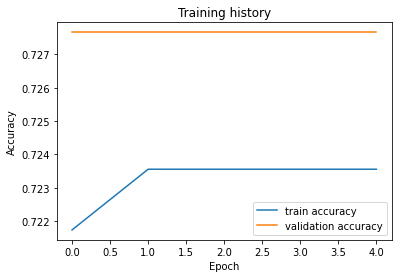

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1])

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
class_name = ['Not_offensive' ,'Offensive_Untargetede' ,'Offensive_Targeted_Insult_Group' ,
'Offensive_Targeted_Insult_Individual' ,'not-Tamil' ,'Offensive_Targeted_Insult_Other' ]

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0, digits=4))

                                      precision    recall  f1-score   support

                       Not_offensive     0.7263    1.0000    0.8415      3190
               Offensive_Untargetede     0.0000    0.0000    0.0000       368
     Offensive_Targeted_Insult_Group     0.0000    0.0000    0.0000       288
Offensive_Targeted_Insult_Individual     0.0000    0.0000    0.0000       315
                           not-Tamil     0.0000    0.0000    0.0000       160
     Offensive_Targeted_Insult_Other     0.0000    0.0000    0.0000        71

                            accuracy                         0.7263      4392
                           macro avg     0.1211    0.1667    0.1402      4392
                        weighted avg     0.5275    0.7263    0.6112      4392

